In [ ]:
import librosa
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

Streaming output truncated to the last 5000 lines.
Processed: 03-01-06-01-02-01-12.wav → Emotion: 5
Processed: 03-01-01-01-02-02-12.wav → Emotion: 0
Processed: 03-01-03-01-01-01-12.wav → Emotion: 2
Processed: 03-01-08-01-01-01-12.wav → Emotion: 7
Processed: 03-01-02-01-01-01-12.wav → Emotion: 1
Processed: 03-01-03-02-01-02-12.wav → Emotion: 2
Processed: 03-01-02-01-01-02-12.wav → Emotion: 1
Processed: 03-01-08-01-01-02-12.wav → Emotion: 7
Processed: 03-01-02-02-01-01-12.wav → Emotion: 1
Processed: 03-01-05-01-01-02-12.wav → Emotion: 4
Processed: 03-01-03-01-02-02-12.wav → Emotion: 2
Processed: 03-01-05-02-01-02-12.wav → Emotion: 4
Processed: 03-01-07-01-01-01-12.wav → Emotion: 6
Processed: 03-01-03-02-02-02-12.wav → Emotion: 2
Processed: 03-01-08-02-02-02-12.wav → Emotion: 7
Processed: 03-01-08-02-02-01-12.wav → Emotion: 7
Processed: 03-01-08-02-01-01-12.wav → Emotion: 7
Processed: 03-01-08-02-01-02-12.wav → Emotion: 7
Processed: 03-01-08-01-02-02-12.wav → Emotion: 7
Processed: 03-01-0

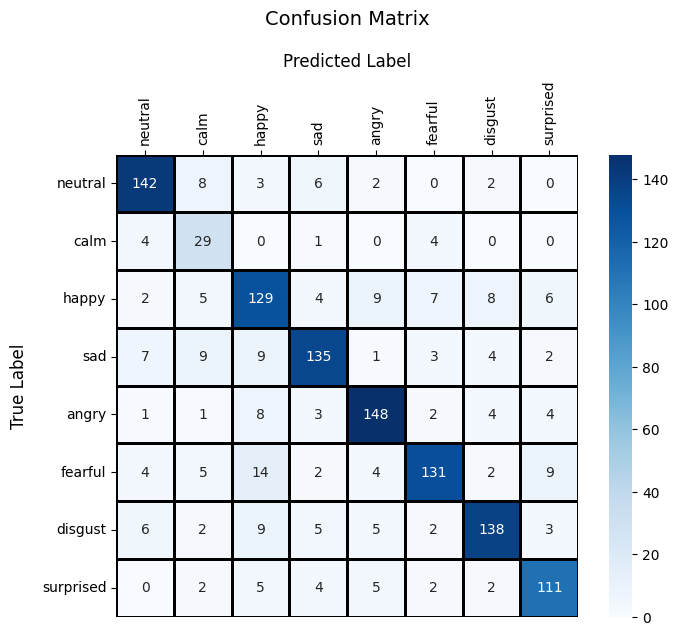

Model saved to ser_model.pkl
Scaler saved to scaler.pkl


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/Speech Audio Datasets"

EMOTION_LABELS = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}

FEATURE_MATRIX_PATH = "X.npy"
LABELS_PATH = "y.npy"
MODEL_PATH = "ser_model.pkl"


def extract_features(file_path):

    signal, sr = librosa.load(file_path, sr=16000)
    signal = librosa.util.normalize(signal)

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    delta_mfccs = librosa.feature.delta(mfccs)
    # delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    pitches, magnitudes = librosa.core.piptrack(y=signal, sr=sr)
    pitch = np.max(pitches, axis=0)
    energy = librosa.feature.rms(y=signal)
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    # spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
    # chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
    teo = np.zeros(len(signal) - 2)
    for i in range(1, len(signal) - 1):
        teo[i-1] = signal[i]**2 - signal[i-1] * signal[i+1]


    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)

    delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
    delta_mfccs_std =np.std(delta_mfccs, axis=1)

    # delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
    # delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

    pitch_median = np.median(pitch)
    pitch_std = np.std(pitch)

    energy_mean = np.mean(energy)
    energy_std = np.std(energy)

    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    # spectral_contrast_std = np.std(spectral_contrast, axis=1)

    # chroma_mean = np.mean(chroma, axis=1)
    # chroma_std = np.std(chroma, axis=1)

    teo_mean = np.mean(teo)
    teo_std = np.std(teo)


    return np.hstack([
        mfccs_mean, mfccs_std,
        delta_mfccs_mean, delta_mfccs_std,
        # delta2_mfccs_mean,  delta2_mfccs_std,
        pitch_median, pitch_std,
        energy_mean, energy_std,
        zcr_mean, zcr_std,
        # spectral_contrast_mean, spectral_contrast_std,
        # chroma_mean, chroma_std
        teo_mean, teo_std
    ])

def prepare_dataset():
    features = []
    labels = []

    for root, _, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)

                features.append(extract_features(file_path))

                emotion_code = int(file.split("-")[2])
                labels.append(emotion_code - 1)

                print(f"Processed: {file} → Emotion: {labels[-1]}")

    np.save(FEATURE_MATRIX_PATH, np.array(features))
    np.save(LABELS_PATH, np.array(labels))
    print(f"Saved features to {FEATURE_MATRIX_PATH} and {LABELS_PATH}")




def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))

    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=labels, yticklabels=labels,
                     linewidths=1, linecolor='black', square=True,
                     cbar_kws={"orientation": "vertical"})

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
    plt.ylabel("True Label", fontsize=12, labelpad=10)
    plt.title("Confusion Matrix", fontsize=14, pad=20)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

def train_model():
    X = np.load(FEATURE_MATRIX_PATH)
    y = np.load(LABELS_PATH)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # class_weight = {0: 1.061, 1: 2.0, 2: 0.905, 3: 0.905, 4: 0.905, 5: 0.905, 6: 0.905, 7: 0.905} only if calm dosent find its grip after training slap him with this
    model = SVC(kernel="linear", C=1.0, class_weight= "balanced")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    # print("Confusion Matrix:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    plot_confusion_matrix(cm, list(EMOTION_LABELS.values()))


    joblib.dump(model, MODEL_PATH)
    joblib.dump(scaler, "scaler.pkl")
    print(f"Model saved to {MODEL_PATH}")
    print("Scaler saved to scaler.pkl")

def predict_emotion(file_path):

    model = joblib.load(MODEL_PATH)

    scaler = joblib.load("scaler.pkl")
    features = extract_features(file_path)
    features = scaler.transform([features])
    emotion_code = model.predict(features)[0]
    return EMOTION_LABELS[emotion_code]

if __name__ == "__main__":

    prepare_dataset()
    train_model()

# print("\nGive me an audio file, and I'll tell you its emotions!")
# xz = input("Enter file path here: ")
# print(f"\nYour speech conveys '{predict_emotion(xz)}' emotion!")


In [ ]:
def check_dataset():
    emotion_counts = {i: 0 for i in range(8)}
    for root,_, files in os.walk(DATASET_PATH):
      for file in files:
        if file.endswith(".wav"):
            emotion_code = int(file.split("-")[2]) - 1
            emotion_counts [emotion_code] += 1
    total = sum(emotion_counts.values())
    print(f"Total files: {total}")
    for code, count in emotion_counts.items():
      print (f" {EMOTION_LABELS [code]}: {count} files")
check_dataset()

Total files: 5920
 neutral: 816 files
 calm: 192 files
 happy: 852 files
 sad: 852 files
 angry: 852 files
 fearful: 852 files
 disgust: 852 files
 surprised: 652 files


In [ ]:
print("\nGive me an audio file, and I'll tell you its emotions!")
xz = input("Enter file path here: ")
print(f"\nYour speech conveys '{predict_emotion(xz)}' emotion!")


Give me an audio file, and I'll tell you its emotions!
Enter file path here: /content/neutral.wav


NameError: name 'predict_emotion' is not defined